In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from time import time
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from Historic_Crypto import HistoricalData
from Historic_Crypto import Cryptocurrencies
from Historic_Crypto import LiveCryptoData
import yfinance as yf
import os

In [14]:
print("PyTorch version " + torch.__version__)
print("Num GPUs Available: ", torch.cuda.device_count())
print(torch.cuda.is_available())

PyTorch version 1.13.1
Num GPUs Available:  1
True


In [15]:
class DDDQN(torch.nn.Module):
    def __init__(self, input_features, window_size):
        super().__init__()
        self.input_size = input_features * window_size  # input size
        # The use of LeakyReLU activation functions can help alleviate the vanishing gradient problem
        self.leaky_relu = torch.nn.LeakyReLU(negative_slope=0.1) 
        
        # Dueling DQN architecture
        self.d1 = torch.nn.Linear(self.input_size, 256)  # input layer
        self.bn1 = torch.nn.BatchNorm1d(256)  # batch normalization  used to normalize the input layer by adjusting and scaling the activations
        self.d2 = torch.nn.Linear(256, 512)  # hidden layer
        self.bn2 = torch.nn.BatchNorm1d(512)  # batch normalization used to normalize the input layer by adjusting and scaling the activations
        self.drop1 = torch.nn.Dropout(0.3)  # dropout layer used to prevent overfitting
        self.d3 = torch.nn.Linear(512, 512)  # hidden layer
        self.bn3 = torch.nn.BatchNorm1d(512)  # batch normalization used to normalize the input layer by adjusting and scaling the activations
        self.drop2 = torch.nn.Dropout(0.3)  # dropout layer used to prevent overfitting
        self.d4 = torch.nn.Linear(512, 256)  # hidden layer
        self.bn4 = torch.nn.BatchNorm1d(256)    # batch normalization used to normalize the input layer by adjusting and scaling the activations
        self.drop3 = torch.nn.Dropout(0.3)  # dropout layer used to prevent overfitting
        self.dv1 = torch.nn.Linear(256, 128)  # value hidden layer
        self.da1 = torch.nn.Linear(256, 128)  # actions hidden layer
        self.dv2 = torch.nn.Linear(128, 1)  # value output
        self.da2 = torch.nn.Linear(128, 9)  # actions output

    # forward propagation
    def forward(self, input_data):
        input_data = input_data.reshape(input_data.size(0), -1)  # Flatten the input tensor
        x = self.leaky_relu(self.d1(input_data))  # activation function
        x = self.bn1(x)  # batch normalization
        x = x.view(x.size(0), -1)  # equivalent to Flatten()
        x = self.leaky_relu(self.d2(x))  # activation function
        x = self.bn2(x)  # batch normalization
        x = self.drop1(x)  # dropout
        x = self.leaky_relu(self.d3(x))  # activation function
        x = self.bn3(x)  # batch normalization
        x = self.drop2(x)  # dropout
        x = self.leaky_relu(self.d4(x))   # activation function
        x = self.bn4(x)  # batch normalization
        x = self.drop3(x)  # dropout
        v = self.leaky_relu(self.dv1(x))  # value function
        a = self.leaky_relu(self.da1(x))  # actions function
        v = self.dv2(v)     # value output
        a = self.da2(a)   # actions output
        Q = v + (a - torch.mean(a, dim=1, keepdim=True)) # dueling Q values
        return Q   # return Q values
    
    # advantage function is used to calculate the advantage of taking each action at each state
    # processes the input state through the common layers and then the advantage stream layers.
    # used for debugging or analysis purposes.
    def advantage(self, state):
        # Common processing
        x = self.leaky_relu(self.d1(state))
        x = self.bn1(x)
        x = self.leaky_relu(self.d2(x))
        x = self.bn2(x)
        x = self.drop1(x)
        x = self.leaky_relu(self.d3(x))
        x = self.bn3(x)
        x = self.drop2(x)
        x = self.leaky_relu(self.d4(x))
        x = self.bn4(x)
        x = self.drop3(x)

        # Advantage stream processing
        a = self.leaky_relu(self.da1(x))  # actions function 
        a = self.da2(a) # actions output

        return a  # return advantage values


In [16]:
import numpy as np
import torch

# The sumtree is used to store the priorities of the experiences it receives and to sample the experiences based on their priorities.
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity   # capacity of the sumtree
        self.tree = np.zeros(2 * capacity - 1) # stores the priorities
        self.data = np.zeros(capacity, dtype=object)  # stores the experiences
        self.write = 0  # pointer to the next experience to be stored
        self.n_entries = 0  # number of experiences stored

    def _propagate(self, idx, change): # propagate the change in the priority value up the tree
        parent = (idx - 1) // 2  # parent node
        self.tree[parent] += change  # update the priority value
        if parent != 0:  # if the parent node is not the root node
            self._propagate(parent, change)  # propagate the change in the priority value up the tree

    def _retrieve(self, idx, s):  # retrieve the experience based on the priority value
        left = 2 * idx + 1  # left node
        right = left + 1  # right node
        if left >= len(self.tree):  # if the left node is a leaf node
            return idx  # return the index of the leaf node
        if s <= self.tree[left]:  # if the priority value is less than or equal to the priority value of the left node
            return self._retrieve(left, s)  # retrieve the experience from the left node
        else: # if the priority value is greater than the priority value of the left node
            return self._retrieve(right, s - self.tree[left])  # retrieve the experience from the right node

    def total(self):  # return the total priority value of the sumtree
        return self.tree[0]  # return the priority value of the root node

    def add(self, data, p):  # add the experience and its priority value to the sumtree
        idx = self.write + self.capacity - 1  # index of the leaf node
        self.data[self.write] = data  # store the experience
        self.update(idx, p)  # update the priority value of the leaf node
        self.write += 1  # increment the pointer to the next experience to be stored
        if self.write >= self.capacity:  # if the pointer to the next experience to be stored exceeds the capacity of the sumtree
            self.write = 0  # reset the pointer to the next experience to be stored
        if self.n_entries < self.capacity:   # if the number of experiences stored is less than the capacity of the sumtree
            self.n_entries += 1  # increment the number of experiences stored

    def update(self, idx, p): # update the priority value of the leaf node
        change = p - self.tree[idx] # change in the priority value
        self.tree[idx] = p # update the priority value
        self._propagate(idx, change) # propagate the change in the priority value up the tree

    def get(self, s): # retrieve the experience based on the priority value
        idx = self._retrieve(0, s)  # retrieve the experience
        dataIdx = idx - self.capacity + 1 # index of the experience
        return idx, self.tree[idx], self.data[dataIdx]  # return the index of the experience, the priority value of the experience, and the experience

# The prioritized experience replay buffer is used to store the experiences and sample the experiences based on their priorities.
class PrioritizedExpReplay():    
    def __init__(self, num_features, window_size, device, buffer_size=1000000, alpha=0.6, beta=0.4): # initialize the prioritized experience replay buffer
        self.tree = SumTree(buffer_size) # initialize the sumtree
        self.alpha = alpha # initialize the alpha value
        self.beta = beta    # initialize the beta value
        self.device = device    # initialize the device (GPU)
        self.buffer_size = buffer_size # initialize the capacity of the sumtree
        self.window_size = window_size # initialize the window size
        self.num_features = num_features    # initialize the number of features

    def add_exp(self, state, action, reward, next_state, done):
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        if max_priority == 0:
            max_priority = 1
        exp = (state, action, reward, next_state, done)
        self.tree.add(exp, max_priority ** self.alpha)

    def sample_exp(self, batch_size=64):
        batch = []
        idxs = []
        segment = self.tree.total() / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = np.random.uniform(a, b)
            idx, p, exp = self.tree.get(s)
            priorities.append(p)
            batch.append(exp)
            idxs.append(idx)

        sampling_probabilities = np.array(priorities) / self.tree.total()
        is_weights = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weights /= np.max(is_weights)

        
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.bool).to(self.device)
        is_weights = torch.tensor(is_weights, dtype=torch.float32).to(self.device)
        
        return states, actions, rewards, next_states, dones, idxs, is_weights

    def update_priorities(self, idxs, td_errors):
        priorities = np.abs(td_errors) + 1e-5
        for idx, priority in zip(idxs, priorities):
            self.tree.update(idx, priority ** self.alpha)


In [17]:
class Agent():

    # Initializes the agent with various parameters such as window_size, gamma, number of episodes, learning rate, minimum epsilon, and update interval. 
    # It also initializes the device, portfolio, epsilon, training step counter, memory, batch size, online and target networks, optimizer, scheduler, 
    # and the holding time.
    def __init__(self, data_shape, num_episodes, window_size=30, gamma=0.99, update_interval=30, lr=0.001, min_epsilon=0.02):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print('Agent is using device: ', self.device)
        self.window_size = window_size  # number of previous prices to use as state
        self.data_shape = data_shape  # [num_features, window_size]
        self.portfolio = [0, 0, 0, 0]  # [total eth, cash_held, total_portfolio_value (eth value + cash held - initial investment), max ether held so far]
        self.inventory = [] 
        self.gamma = gamma  # discount factor for future rewards
        self.num_episodes = num_episodes    # number of episodes
        self.epsilon = 1.0  # exploration rate
        self.min_epsilon = min_epsilon   # minimum exploration rate
        self.update_interval = update_interval  # number of steps between target network updates
        self.trainstep = 0
        # self.memory = ExpReplay(self.window_size, data_shape[1], self.device)        
        self.memory = PrioritizedExpReplay(self.window_size, data_shape[1], self.device)
        self.batch_size = 64
        self.online_net = DDDQN(self.data_shape[1], window_size).to(self.device)
        self.target_net = DDDQN(self.data_shape[1], window_size).to(self.device)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.holding_time = 0 # Number of timesteps for which the agent has held the position
        initial_learning_rate = lr
        decay_steps = self.num_episodes * self.data_shape[0] // 10  # You can adjust the divisor to control the decay rate
        decay_rate = 0.9  # You can adjust this value to control the decay rate
        self.optimizer = optim.Adam(self.online_net.parameters(), lr=initial_learning_rate)
        self.scheduler = ExponentialLR(self.optimizer, gamma=decay_rate)
        self.criterion = nn.MSELoss()

    # CURRICULUM TRAINING PART 1
    def get_action(self, state):
            state_numpy = np.array(state)
            state_tensor = torch.FloatTensor(state_numpy).to(self.device).unsqueeze(0)
            # create a random number between 0 and 1 and compare it to epsilon for our epsilon-greedy algorithm
            if np.random.rand() <= self.epsilon:
                # Select a random action out of the list of available actions
                if len(self.inventory) > 0:  # if we have inventory to sell
                    return np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8])
                else:
                    return np.random.choice([4, 5, 6, 7, 8])  # we can only buy or hold
            else:
                with torch.no_grad():
                    self.online_net.eval()
                    actions = self.online_net(state_tensor)
                    # actions = self.online_net.advantage(state_tensor)
                    self.online_net.train()

                    if len(self.inventory) > 0:
                        action = torch.argmax(actions[0, :]).item()
                    else: # if we don't have inventory to sell, we remove that action option
                        action = torch.argmax(actions[0, 4:]).item() + 4
                    return action
                
    # CURRICULUM TRAINING PART 2
    def get_action_curriculum_2(self, state, balance):
            state_numpy = np.array(state)
            state_tensor = torch.FloatTensor(state_numpy).to(self.device).unsqueeze(0)
            # create a random number between 0 and 1 and compare it to epsilon for our epsilon-greedy algorithm
            if np.random.rand() <= self.epsilon:
                # Select a random action out of the list of available actions
                if len(self.inventory) > 0 and balance >= 0:  # if we have inventory to sell and balance is greater than 10
                    return np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8])
                elif len(self.inventory) > 0 and balance <= 0: # if we have inventory to sell and balance is less than 10
                    return np.random.choice([0, 1, 2, 3, 4])  # we can only sell or hold
                elif len(self.inventory) == 0 and balance >= 0: # if we don't have inventory to sell and balance is greater than 10
                    return np.random.choice([4, 5, 6, 7, 8])  # we can only buy or hold
                else: # if we don't have inventory to sell and balance is less than 10
                    return 4 # we can only hold

            else:
                with torch.no_grad():
                    self.online_net.eval()
                    actions = self.online_net(state_tensor)
                    # actions = self.online_net.advantage(state_tensor)
                    self.online_net.train()

                    if len(self.inventory) > 0 and balance >= 0:
                        action = torch.argmax(actions[0, :]).item()
                    elif len(self.inventory) > 0 and balance <= 0:
                        action = torch.argmax(actions[0, :5]).item()
                    elif len(self.inventory) == 0 and balance >= 0:
                        action = torch.argmax(actions[0, 4:]).item() + 4
                    else:
                        action = 4
                    return action

    # # CURRICULUM TRAINING PART 2
    # # Takes the current state and cash balance as inputs and returns an action based on epsilon-greedy exploration strategy.
    # # It returns an action between 0 and 8, depending on the random number generated and the current portfolio status.
    # def get_action(self, state, cash_balance):
    #     eth_held = self.portfolio[0]
    #     cash_held = self.portfolio[1]
    #     total_portfolio_value = self.portfolio[2]
    #     max_eth_held = self.portfolio[3]
    #     state_numpy = np.array(state)
    #     state_tensor = torch.FloatTensor(state_numpy).to(self.device).unsqueeze(0)
    #     if np.random.rand() <= self.epsilon:
    #         # print("Random action based on epsilon")
    #         if eth_held > 0.001 and cash_balance >= 10 and len(self.inventory) > 0:# if we have ether and cash
    #             # print("we have ether and cash so our options are [0, 1, 2, 3, 4, 5, 6, 7, 8]")
    #             return np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8])  # we can perform any action
    #         elif eth_held > 0.001 and cash_balance < 10:  # if we have ether but no cash
    #             # print("we have ether but no cash so our options are [0, 1, 2, 3, 4]")
    #             return np.random.choice([0, 1, 2, 3, 4])  # we can only sell or hold
    #         elif eth_held <= 0.001 and cash_balance >= 10:  # if we have cash but no ether
    #             # print("we have cash but no ether so our options are [4, 5, 6, 7, 8]")
    #             return np.random.choice([4, 5, 6, 7, 8])  # we can only buy or hold
    #         else:
    #             # print("we have neither cash nor ether so our only option is 4")
    #             action = 4  # hold
    #             return action
    #     else:
    #         # print("Action based on neural network output")
    #         with torch.no_grad():
    #             self.online_net.eval()
    #             actions = self.online_net(state_tensor)
    #             self.online_net.train()
    #             # print(f"Neural network output: {actions}")
                
    #             if eth_held > 0.001 and cash_balance >= 10:
    #                 # print("we have ether and cash so our options are [0, 1, 2, 3, 4, 5, 6, 7, 8]")
    #                 action = torch.argmax(actions[0, :]).item()
    #             elif eth_held > 0.001 and cash_balance < 10:
    #                 # print("we have ether but no cash so our options are [0, 1, 2, 3, 4]")
    #                 action = torch.argmax(actions[0, :5]).item()
    #             elif eth_held <= 0.001 and cash_balance >= 10:
    #                 # print("we have cash but no ether so our options are [4, 5, 6, 7, 8]")
    #                 action = torch.argmax(actions[0, 4:]).item() + 4
    #             else:
    #                 # print("we have neither cash nor ether so our only option is 4")
    #                 action = 4
        
    #     # print(f"Selected action: {action}")
    #     return action



    #  This method softly updates the target network by blending the weights of the online network and target network using the parameter tau.
    def update_target(self, tau=0.001):
        for target_param, online_param in zip(self.target_net.parameters(), self.online_net.parameters()):
            target_param.data.copy_(tau * online_param.data + (1.0 - tau) * target_param.data)

    #  Linearly decays the epsilon value from its initial value to the minimum epsilon value over the course of the total training steps.
    def update_epsilon(self):
        if self.epsilon > self.min_epsilon:
            # b = self.min_epsilon**(1/(self.num_episodes*self.data_shape[0]))
            # self.epsilon = b**self.trainstep # exponential decay
            self.epsilon -= (1.0 - self.min_epsilon) / (self.num_episodes * self.data_shape[0])   # linear decay

    # Trains the online network using the samples from the prioritized experience replay memory. 
    # It updates the target network periodically based on the update_interval. 
    # It also calculates the loss, applies the importance sampling weights, and updates the priorities in the buffer.
    def train(self):
        if self.memory.tree.n_entries < self.batch_size:
            return

        if self.trainstep % self.update_interval == 0:
            self.update_target()

        states, actions, rewards, next_states, dones, idxs, is_weights = self.memory.sample_exp(self.batch_size)

        q_next_state_online_net = self.online_net(next_states)
        q_next_state_target_net = self.target_net(next_states)

        max_action = torch.argmax(q_next_state_online_net, dim=1).to(self.device)

        batch_index = torch.arange(self.batch_size, dtype=torch.int64).to(self.device)

        q_predicted = self.online_net(states)
        q_target = q_predicted.clone().detach()

        q_target[batch_index, actions] = rewards + self.gamma * q_next_state_target_net[batch_index, max_action] * dones

        td_errors = q_target - q_predicted
        td_errors = td_errors.detach().cpu().numpy()
        td_errors = td_errors[np.arange(self.batch_size), actions.cpu().numpy()]

        # Update priorities in the buffer
        self.memory.update_priorities(idxs, td_errors)

        # loss = self.criterion(q_predicted, q_target)
        # loss *= is_weights  # Apply importance sampling weights
        # loss = loss.mean()

        loss = self.criterion(q_predicted, q_target).view(-1, 1)
        loss = (loss * is_weights).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_epsilon()
        self.trainstep += 1
        return loss.item()

    # This method is called to save the model parameters of the online and target networks in the Output folder.
    def save_model(self):
        import os

        output_directory = "Output"
        online_model_directory = os.path.join(output_directory, "online_model")
        target_model_directory = os.path.join(output_directory, "target_model")

        os.makedirs(online_model_directory, exist_ok=True)
        os.makedirs(target_model_directory, exist_ok=True)

        torch.save(self.online_net.state_dict(), os.path.join(online_model_directory, 'model.pt'))
        torch.save(self.target_net.state_dict(), os.path.join(target_model_directory, 'model.pt'))

    # This method is called to load the model parameters of the online and target networks from the Output folder.
    def load_model(self):
        import os

        output_directory = "Output"
        online_model_directory = os.path.join(output_directory, "online_model")
        print("loaded model from: ", online_model_directory)
        target_model_directory = os.path.join(output_directory, "target_model")
        print("loaded model from: ", target_model_directory)


        self.online_net.load_state_dict(torch.load(os.path.join(online_model_directory, 'model.pt')))
        self.target_net.load_state_dict(torch.load(os.path.join(target_model_directory, 'model.pt')))

    # This method is called to calculate the reward for the sell action.
    # def calculate_sell_reward(self, t, eth_df, eth_close_price_unscaled, amount_to_sell, initial_investment, trading_fee_rate):
    #     ether_held, cash_held, previous_portfolio_value, max_ether_held_so_far = self.portfolio

    #     unscaled_close_price = eth_close_price_unscaled["Close"].iloc[t]
    #     value_of_eth_sold = unscaled_close_price * amount_to_sell
    #     trading_fee = value_of_eth_sold * trading_fee_rate
    #     cash_received = value_of_eth_sold - trading_fee
    #     new_cash_held = cash_held + cash_received
    #     new_ether_held = ether_held - amount_to_sell

    #     # Calculate portfolio value
    #     # new_portfolio_value = new_cash_held + (new_ether_held * unscaled_close_price) - initial_investment
    #     new_portfolio_value = new_cash_held + (new_ether_held * unscaled_close_price)
    #     # Calculate the reward based on the change in portfolio value
    #     reward = (new_portfolio_value - previous_portfolio_value) / initial_investment

    #     # Update portfolio
    #     self.portfolio = [new_ether_held, new_cash_held, new_portfolio_value, max_ether_held_so_far]

    #     # Add a bonus if the portfolio value is greater than the initial investment
    #     if new_portfolio_value > initial_investment:
    #         bonus = min((new_portfolio_value - initial_investment) / initial_investment, 0.5)
    #         reward = reward * (1 + bonus)

    #     return reward

    # # This method is called to calculate the reward for the buy action.
    # def calculate_buy_reward(self, t, eth_df, eth_close_price_unscaled, eth_to_buy, cash_spent, initial_investment):
    #     ether_held, cash_held, previous_portfolio_value, max_ether_held_so_far = self.portfolio

    #     unscaled_close_price = eth_close_price_unscaled["Close"].iloc[t]
    #     eth_received = eth_to_buy  # trading fee is already accounted for in the amount of ETH to buy
    #     new_cash_held = cash_held - cash_spent
    #     new_ether_held = ether_held + eth_received
    #     # Calculate portfolio value
    #     # new_portfolio_value = new_cash_held + (new_ether_held * unscaled_close_price) - initial_investment
    #     new_portfolio_value = new_cash_held + (new_ether_held * unscaled_close_price)
    #     # Calculate the reward based on the change in portfolio value
    #     # reward = (new_portfolio_value - previous_portfolio_value) / initial_investment
    #     reward_eth_held = (new_ether_held - max_ether_held_so_far) / (new_ether_held + max_ether_held_so_far)

    #     if new_ether_held > max_ether_held_so_far:
    #         max_ether_held_so_far = new_ether_held
        
    #     # Combine the rewards
    #     reward = reward_eth_held

    #     # Update portfolio
    #     self.portfolio = [new_ether_held, new_cash_held, new_portfolio_value, max_ether_held_so_far]

    #     # Add a bonus if the portfolio value is greater than the initial investment
    #     if new_portfolio_value > initial_investment:
    #         bonus = min((new_portfolio_value - initial_investment) / initial_investment, 0.5)
    #         reward = reward * (1 + bonus)

    #     return reward

    # # Takes an action and updates the portfolio accordingly. 
    # # It calculates the reward for the action and applies a penalty if the agent doesn't have enough 
    # # Ethereum or cash balance to perform the requested action.
    # def trade(self, t, action, eth_df, eth_df_unscaled, initial_investment, trading_fee_rate):
    #     reward = 0
    #     eth_held, cash_balance, previous_portfolio_value, max_ether_held_so_far = self.portfolio
    #     sell_percentages = [0.25, 0.5, 0.75, 1.0]
    #     buy_percentages = [0.25, 0.5, 0.75, 1.0]

    #     # SELL
    #     if action >= 0 and action <= 3:
    #         print("SELL with action: ", action)
    #         # Reset holding time when selling
    #         self.holding_time = 0
    #         sell_percentage = sell_percentages[action]
    #         amount_to_sell = eth_held * sell_percentage

    #         while amount_to_sell > 0 and eth_held > 0.001:

    #             reward = self.calculate_sell_reward(t, eth_df, eth_df_unscaled, amount_to_sell, initial_investment, trading_fee_rate)

    #             eth_held, cash_balance, current_portfolio_value, max_ether_held_so_far = self.portfolio  # Update portfolio after selling
    #             amount_to_sell = 0
    #     # HOLD
    #     elif action == 4:
    #         print("HOLD with action: ", action)
    #         # self.portfolio[2] = cash_balance + (eth_held * eth_df_unscaled["Close"].iloc[t]) - initial_investment
    #         self.portfolio[2] = cash_balance + (eth_held * eth_df_unscaled["Close"].iloc[t])
    #         # Increment holding time when holding
    #         self.holding_time += 1
    #         # Apply a holding time reward
    #         reward = -0.01 * self.holding_time
    #     # BUY
    #     elif action >= 5:
    #         print("BUY with action: ", action)
    #         # Reset holding time when buying
    #         self.holding_time = 0
    #         buy_percentage = buy_percentages[action - 5]
    #         money_to_spend = (cash_balance * buy_percentage)
    #         trading_fee = money_to_spend * trading_fee_rate
    #         eth_to_buy = (money_to_spend - trading_fee) / eth_df_unscaled["Close"].iloc[t]
    #         cash_spent = eth_to_buy * eth_df_unscaled["Close"].iloc[t]

    #         reward = self.calculate_buy_reward(t, eth_df, eth_df_unscaled, eth_to_buy, cash_spent, initial_investment)

    #     return reward
    
    def trade(self, t, action, eth_df, eth_df_unscaled, initial_investment, trading_fee_rate):
        eth_held, balance, previous_portfolio_value, max_ether_held_so_far = self.portfolio
        reward = 0
        if action >= 0 and action <= 3:
            reward = eth_df_unscaled["Close"].iloc[t] - self.inventory.pop() 
        elif action == 4:
            reward = -0.1
            pass
        elif action >= 5 and balance >= eth_df_unscaled["Close"].iloc[t]:
            self.inventory.append(eth_df_unscaled["Close"].iloc[t])
        return reward
    
    def trade_curriculum_2(self, t, action, eth_df, eth_df_unscaled, initial_investment, trading_fee_rate):
        eth_held, balance, previous_portfolio_value, max_ether_held_so_far = self.portfolio
        buy_percentages = [0.25, 0.5, 0.75, 1.0]
        reward = 0
        if action >= 0 and action <= 3:  # SELL
            previous_eth_bought, previous_price_paid = self.inventory.pop()
            reward = ((eth_df_unscaled["Close"].iloc[t] * previous_eth_bought) * (1 - trading_fee_rate)) - previous_price_paid
            self.portfolio[0] = sum([i[0] for i in self.inventory])  # this takes the first element of each tuple in the inventory list and sums them
            self.portfolio[1] += reward
        elif action == 4:  # HOLD
            pass
        elif action >= 5:  # BUY
            # amount of cash spent accounting for trading fee
            cash_spent = (balance * buy_percentages[action - 5]) * (1 - trading_fee_rate)
            eth_to_buy = cash_spent / eth_df_unscaled["Close"].iloc[t]
            self.inventory.append((eth_to_buy, cash_spent))
            self.portfolio[0] = sum([i[0] for i in self.inventory])  # this takes the first element of each tuple in the inventory list and sums them
            self.portfolio[1] -= cash_spent

        return reward

    def get_state(self, t, eth_df):
        num_rows = t - self.window_size + 1
        if num_rows >= 0:
            window = eth_df.iloc[num_rows : t + 1]
        else:
            repeated_first_row = pd.concat([pd.DataFrame(np.repeat(eth_df.iloc[[0]].values, -num_rows, axis=0), columns=eth_df.columns)])
            new_data = eth_df.iloc[0 : t + 1]
            window = pd.concat([repeated_first_row, new_data], ignore_index=True)  # prevents us from sampling data that doesn't exist at the start.
        return window.values


In [18]:
def get_crypto_data(start_date, end_date, split_date):
    try:
        train = pd.read_csv("Datasets/train_eth.csv", index_col=0)
        test = pd.read_csv("Datasets/test_eth.csv", index_col=0)
    except:
        df = HistoricalData('ETH-USD', 3600, start_date, end_date).retrieve_data()  # 3600 is the interval in seconds which is 1 hour
        split_row = df.index.get_loc(split_date)
        cols = df.columns.tolist()
        df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=cols)
        train = df[:split_row]
        test = df[split_row:]
        train.to_csv("Datasets/train_eth.csv")
        test.to_csv("Datasets/test_eth.csv")
    return train, test

In [19]:
def get_crypto_data(start_date, end_date):
    historic_data_df = HistoricalData('ETH-USD', 21600, start_date, end_date).retrieve_data()  # 3600 is the interval in seconds which is 1 hour
    cols = historic_data_df.columns.tolist()
    historic_data_df = pd.DataFrame(MinMaxScaler().fit_transform(historic_data_df), columns=cols)
    historic_data_df.to_csv("Datasets/train_eth.csv")
    return historic_data_df

In [20]:
# pre-collected data
def get_precollected_data(split_ratio=0.8):
    # try:
    historic_data = pd.read_csv("Datasets/eth_historical_data_simple.csv", index_col=0)
    print('Pre-collected data loaded successfully.')
    # convert date to datetime if it isn't the index
    if historic_data.index.name != 'Date':
        historic_data['Date'] = pd.to_datetime(historic_data['Date'], infer_datetime_format=True)
        print('Date converted to datetime.')
        # set date as index
        historic_data = historic_data.set_index('Date')
        print('Date set as index.')
    # drop nan values
    historic_data = historic_data.dropna()
    print('NaN values dropped.')
    cols = historic_data.columns.tolist()
    train_unscaled, test_unscaled = train_test_split(historic_data, train_size=split_ratio,shuffle=False)
    train_scaled = pd.DataFrame(MinMaxScaler().fit_transform(train_unscaled), columns=cols)
    test_scaled = pd.DataFrame(MinMaxScaler().fit_transform(test_unscaled), columns=cols)
    print('Data split.')
    # set the index to the date
    train_unscaled = pd.DataFrame(train_unscaled,  columns=cols)
    test_unscaled = pd.DataFrame(test_unscaled,  columns=cols)
    # convert train_unscaled and test_unscaled to df with only the Open, High, Low, and Close column
    train_unscaled = train_unscaled[['Open', 'High', 'Low', 'Close']]
    test_unscaled = test_unscaled[['Open', 'High', 'Low', 'Close']]

    train_unscaled.to_csv("Output/train_unscaled.csv")
    train_scaled.to_csv("Output/train_scaled.csv")
    print('Train data saved.')
    test_unscaled.to_csv("Output/test_unscaled.csv")
    test_scaled.to_csv("Output/test_scaled.csv")
    print('Test data saved.')
    return train_scaled, test_scaled, train_unscaled, test_unscaled
        
    # except:
    #     # throw error
    #     print("No pre-collected data found. Please run the data collection script first.")
    #     exit()

In [21]:
historic_data = pd.read_csv("Datasets/eth_historical_data_simple.csv", index_col=0)

historic_data.head()

,Open,High,Low,Close,Volume,PriceDelta,VolumeDelta,Twitter_Positive,Twitter_Neutral,Twitter_Negative,...,Volume_USDC,VolumeDelta_USDC,7day_Past_Mean_Price,Yesterday_Volume,3day_Past_Mean_Volume,7day_Past_Mean_Volume,Yesterday_Vol_USDT,3day_Past_Mean_Vol_USDT,7day_Past_Mean_Vol_USDT,RSI
Date,,,,,,,,,,,,,,,,,,,,,
7/19/2019,226.657700,226.940475,215.838242,221.333420,7606433131,-5.232742,-1721382928,330.0,2380.0,91.0,...,123323972.0,-46731557.0,226.483728,9327816059,8773998943,8625351483,2.660702e+10,2.550249e+10,2.516096e+10,37.863434
7/20/2019,221.412659,234.198456,221.189484,229.119217,7976245988,7.785797,369812857,492.0,3353.0,122.0,...,97823106.0,-25500866.0,220.720930,7606433131,8303498393,8805268135,2.197717e+10,2.324585e+10,2.512160e+10,40.588868
7/21/2019,229.167694,229.861664,219.027756,225.630768,6685082868,-3.488449,-1291163120,428.0,3566.0,115.0,...,77161429.0,-20661677.0,220.442745,7976245988,7422587329,8534802918,2.115336e+10,2.051297e+10,2.433822e+10,39.747640
7/22/2019,225.698654,226.862579,213.448380,217.560013,6338843919,-8.070755,-346238949,545.0,4293.0,104.0,...,84139079.0,6977650.0,218.697604,6685082868,7000057592,8051255728,1.840836e+10,1.908170e+10,2.288130e+10,37.795917
7/23/2019,217.568466,218.518051,209.638123,212.728516,6976091534,-4.831497,637247615,455.0,4132.0,109.0,...,76690057.0,-7449022.0,220.631867,6338843919,6666672774,7756894448,1.768336e+10,1.836875e+10,2.182387e+10,36.636155


In [22]:
# Curriculmum Learning
def curriculum_1_episode_memory(NUM_EPISODES):
    episode_mem = [{"Actions": [], "Inventory Size": [], "Portfolio Value": [], "Realized Profit": [], "Reward": [], "Done": [], "Epsilon": [], "MSE Loss": []} for i in range(NUM_EPISODES)]
    return episode_mem

def curriculum_2_episode_memory(NUM_EPISODES):
    episode_mem = [{"Actions": [], "Eth Held": [], "Cash Held": [], "Portfolio Value": [], "Reward": [], "Done": [], "Epsilon": [], "MSE Loss": []} for i in range(NUM_EPISODES)]
    return episode_mem

def curriculum_1_test_memory():
    testing_mem = {"Actions": [], "Inventory Size": [], "Portfolio Value": [], "Realized Profit": [], "Reward": [], "Done": []}
    return testing_mem

def curriculum_2_test_memory():
    testing_mem = {"Actions": [], "Eth Held": [], "Cash Held": [], "Portfolio Value": [], "Reward": [], "Done": []}
    return testing_mem

def curriculum_1_train(INITIAL_INVESTMENT, step, trading_agent, train_df, train_close, state, balance):

    action = trading_agent.get_action(state)
    next_state = trading_agent.get_state(step + 1, train_df)
    reward = trading_agent.trade(step, action, train_df, train_close, INITIAL_INVESTMENT, trading_fee_rate = 0.05)
    new_balance = balance + reward
    done = new_balance < train_close["Close"].iloc[step]  # if we run out of money to buy, consider the episode "done"
    trading_agent.memory.add_exp(state, action, reward, next_state, done)
    loss = trading_agent.train()

    return action, next_state, reward, done, loss, new_balance

def curriculum_2_train(INITIAL_INVESTMENT, step, trading_agent, train_df, train_close, state, balance):
    
    action = trading_agent.get_action(state, balance)
    next_state = trading_agent.get_state(step + 1, train_df)
    reward = trading_agent.trade(step, action, train_df, train_close, INITIAL_INVESTMENT, trading_fee_rate = 0.05)
    eth_held, cash_held, new_portfolio_value, max_ether_held_so_far = trading_agent.portfolio
    new_balance = cash_held  # update cash balance
    portfolio_value_usd = new_portfolio_value  # update portfolio value
    
    if step != 0:  # if not the first trade
        done = new_balance <= 10 and eth_held <= 0.001
    trading_agent.memory.add_exp(state, action, reward, next_state, done)
    loss = trading_agent.train()

    return action, next_state, reward, done, loss, new_balance, portfolio_value_usd

def curriculum_1_test(INITIAL_INVESTMENT, step, trading_agent, test_df, test_close, state, balance):
    action = trading_agent.get_action(state)
    next_state = trading_agent.get_state(step + 1, test_df)
    reward = trading_agent.trade(step, action, test_df, test_close, INITIAL_INVESTMENT, trading_fee_rate = 0.05)
    new_balance = balance + reward
    done = new_balance < test_close["Close"].iloc[step]
    state = next_state
    return action, next_state, reward, done, new_balance

def curriculum_2_test(INITIAL_INVESTMENT, step, trading_agent, test_df, test_close, state, balance):
    action = trading_agent.get_action(state, balance)
    next_state = trading_agent.get_state(step + 1, test_df)
    reward = trading_agent.trade(step, action, test_df, test_close, INITIAL_INVESTMENT, trading_fee_rate = 0.05)
    eth_held, cash_held, new_portfolio_value, max_ether_held_so_far  = trading_agent.portfolio
    new_balance = cash_held  # update cash balance
    portfolio_value_usd = new_portfolio_value  # update portfolio value
    if step != 0:  # if not the first trade
        done = new_balance <= 10 and eth_held <= 0.001
    state = next_state

    return action, next_state, reward, done, new_balance, portfolio_value_usd

In [23]:
def main(trading_agent, train_df, test_df, train_close, test_close, curriculum):

    CURRICULUM = curriculum
    
    # CURRICULUM 1
    if CURRICULUM == 1:
        print("Curriculum 1")
        episode_mem = curriculum_1_episode_memory(NUM_EPISODES=NUM_EPISODES)
    # CURRICULUM 2
    elif CURRICULUM == 2:
        episode_mem = curriculum_2_episode_memory(NUM_EPISODES=NUM_EPISODES)

    t0 = time()  # start time of the program

    ######################## Training ########################
    for episode in range(NUM_EPISODES):  
        print(f"\n===== Episode {episode + 1} / {NUM_EPISODES} =====")
        trading_agent.inventory = []
        state = trading_agent.get_state(0, train_df)
        balance = INITIAL_INVESTMENT
        if CURRICULUM == 1:
            portfolio_value_usd = 0
        if CURRICULUM == 2:
            portfolio_value_usd = INITIAL_INVESTMENT
        # Reset the agent's portfolio at the beginning of each episode
        trading_agent.portfolio = [0 , INITIAL_INVESTMENT, portfolio_value_usd, 0]

        done = False
        for t in range(len(train_df) - 1):
            if done:
                break

            # CURRICULUM 1
            if CURRICULUM == 1:
                action, next_state, reward, done, loss, new_balance = curriculum_1_train(INITIAL_INVESTMENT, t, trading_agent, train_df, train_close, state, balance)
                balance = new_balance
                portfolio_value_usd = float(balance + train_close["Close"].iloc[t] * len(trading_agent.inventory) - sum(trading_agent.inventory)) - INITIAL_INVESTMENT
                if not loss:
                    loss = 0
                    state = next_state

                episode_mem[episode]["Actions"].append(int(action))
                episode_mem[episode]["Inventory Size"].append(len(trading_agent.inventory))
                episode_mem[episode]["Portfolio Value"].append(portfolio_value_usd)
                episode_mem[episode]["Realized Profit"].append(float(balance - INITIAL_INVESTMENT))
                episode_mem[episode]["Reward"].append(float(reward))
                episode_mem[episode]["Done"].append(bool(done))
                episode_mem[episode]["Epsilon"].append(trading_agent.epsilon)
                episode_mem[episode]["MSE Loss"].append(loss)

                if t % 100 == 0:
                    print(f"Time step {t} / {len(train_df)}   |   Portfolio Value: {round(episode_mem[episode]['Portfolio Value'][t], 3)}   |   Inventory: {len(trading_agent.inventory)}   |   ETH$: {round(train_close['Close'].iloc[t], 3)}   |   Epsilon: {round(trading_agent.epsilon, 4)}   |   MSE Loss: {loss}")


            
            # CURRICULUM 2
            elif CURRICULUM == 2:
                action, next_state, reward, done, loss, new_balance, new_portfolio_value = curriculum_2_train(INITIAL_INVESTMENT, t, trading_agent, train_df, train_close, state, balance)
                balance = new_balance
                portfolio_value_usd = new_portfolio_value
                eth_held, cash_held, new_portfolio_value, max_ether_held_so_far = trading_agent.portfolio

                if not loss:
                    loss = 0
                    state = next_state

                episode_mem[episode]["Actions"].append(int(action))
                episode_mem[episode]["Eth Held"].append(float(eth_held))
                episode_mem[episode]["Cash Held"].append(round(float(balance), 2))
                episode_mem[episode]["Portfolio Value"].append(float(portfolio_value_usd))
                episode_mem[episode]["Reward"].append(float(reward))
                episode_mem[episode]["Done"].append(bool(done))
                episode_mem[episode]["Epsilon"].append(trading_agent.epsilon)
                episode_mem[episode]["MSE Loss"].append(float(loss))

                if t % 1 == 0:
                    print(f"Time step {t} / {len(train_df)}   |  Eth: {round(episode_mem[episode]['Eth Held'][t], 7)}  |  Cash: {round(episode_mem[episode]['Cash Held'][t], 2)}  |  Portfolio Value: {round(episode_mem[episode]['Portfolio Value'][t], 3)}  |   MSE: {round(episode_mem[episode]['MSE Loss'][t], 3)}  |  Reward: {round(episode_mem[episode]['Reward'][t], 3)}  |  Action: {int(episode_mem[episode]['Actions'][t])}  |  Epsilon: {round(trading_agent.epsilon, 3)}")
            
    if CURRICULUM == 1:
        # if we have leftover inventory at the end of the episode, calculate its value by selling them all at the current market rate
        balance += train_df["Close"].iloc[t] * len(trading_agent.inventory) - sum(trading_agent.inventory)
    
    with open('Output/training_scores.out', 'a') as f:
        f.write(f"EPISODE {episode} (runtime: {time() - t0})   | Portfolio Value is {round(episode_mem[episode]['Portfolio Value'][-1], 3)} Epsilon is {round(trading_agent.epsilon, 3)}   |   MSE Loss is {round(episode_mem[episode]['MSE Loss'][-1], 3)}\n")
    # Save the episode memory to a json file, if one exists, add a number to the end of the file name
    episode_mem_file = "Output/episode_mem.json"

    with open(episode_mem_file, 'w') as f:
        json.dump(episode_mem, f)

######################## Testing ########################
    t0 = time()
    # CURRICULUM 1
    if CURRICULUM == 1:
        testing_mem = curriculum_1_test_memory()
    # CURRICULUM 2
    elif CURRICULUM == 2:
        testing_mem = curriculum_2_test_memory()

    trading_agent.epsilon = 0  # no exploration
    if CURRICULUM == 1:
        trading_agent.inventory = [] # inventory reset

    state = trading_agent.get_state(0, test_df)
    balance = INITIAL_INVESTMENT
    
    if CURRICULUM == 1:
        portfolio_value_usd = 0
    if CURRICULUM == 2:
        portfolio_value_usd = INITIAL_INVESTMENT
    
    # Reset the agent's portfolio at the beginning of each episode
    trading_agent.portfolio = [0 , INITIAL_INVESTMENT, portfolio_value_usd, 0]
    # Reset the agent's portfolio at the beginning of each episode

    done = False
    for t in range(len(test_df) - 1):
        if done:
            print("Done with testing")
            break

        # CURRICULUM 1
        if CURRICULUM == 1:
            action, next_state, reward, done, new_balance = curriculum_1_test(INITIAL_INVESTMENT, t, trading_agent, test_df, test_close, state, balance)
            balance = new_balance

            # CURRICULUM 1
            testing_mem["Actions"].append(int(action))
            testing_mem["Inventory Size"].append(len(trading_agent.inventory))
            testing_mem["Portfolio Value"].append(float(balance + test_close["Close"].iloc[t] * len(trading_agent.inventory) - sum(trading_agent.inventory)) - INITIAL_INVESTMENT)
            testing_mem["Realized Profit"].append(float(balance - INITIAL_INVESTMENT))
            testing_mem["Reward"].append(float(reward))
            testing_mem["Done"].append(bool(done))

            if t % 1 == 0:
                print(f"Time step {t} / {len(test_df)}   |   Inventory Size: {len(trading_agent.inventory)}  |  Portfolio Value: {round(testing_mem['Portfolio Value'][t], 3)}   |  Action: {int(action)}  |  Reward: {round(reward, 3)}")

        # CURRICULUM 2
        elif CURRICULUM == 2:
            action, next_state, reward, done, loss, new_balance, new_portfolio_value = curriculum_2_test(INITIAL_INVESTMENT, t, trading_agent, test_df, test_close, state, balance)
            balance = new_balance
            portfolio_value_usd = new_portfolio_value
            eth_held, cash_held, new_portfolio_value, max_ether_held_so_far = trading_agent.portfolio

            # CURRICULUM 2
            testing_mem["Actions"].append(int(action))
            testing_mem["Eth Held"].append(float(eth_held))
            testing_mem["Cash Held"].append(round(float(balance),2))
            testing_mem["Portfolio Value"].append(float(portfolio_value_usd))
            testing_mem["Reward"].append(float(reward))
            testing_mem["Done"].append(bool(done))

            if t % 1 == 0:
                print(f"Time step {t} / {len(test_df)}   |   Eth Held: {round(testing_mem['Eth Held'][t], 7)}  |  Cash Held: {round(testing_mem['Cash Held'][t], 2)}  |  Portfolio Value: {round(testing_mem['Portfolio Value'][t], 3)}   |  Action: {int(action)}  |  Reward: {round(reward, 3)}")
    
    if CURRICULUM == 1:
        # if we have leftover inventory at the end of the episode, calculate its value by selling them all at the current market rate
        balance += test_close["Close"].iloc[t] * len(trading_agent.inventory) - sum(trading_agent.inventory)

    with open('Output/testing_scores.out', 'a') as f:
        f.write(f"TESTING (runtime: {time() - t0})   |  Portfolio Value is {round(testing_mem['Portfolio Value'][-1], 3)}\n")

    # save the testing memory to a json file
    testing_mem_file = "Output/testing_mem.json"
    with open(testing_mem_file, 'w') as f:
        json.dump(testing_mem, f)

if __name__ == "__main__":
    
    INITIAL_INVESTMENT = 10000
    NUM_EPISODES = 1000
    START_DATE = "2017-01-01-00-00"
    END_DATE = "2020-01-01-00-00"
    TESTING_SPLIT = "2022-01-01-00:00:00" # formatting is different here because of how historic_crypto indexes dataframes
    CURRICULUM = 1

    train_df, test_df, train_close, test_close = get_precollected_data(split_ratio=0.8)
    trading_agent = Agent(train_df.shape, NUM_EPISODES)
    
    # Load the model only once before starting the loop if it exists
    if os.path.exists("Output/online_model/model.pt"):
        print("Loading the model")
        trading_agent.load_model()
    else:
        print("No model found, training from scratch")

    main(trading_agent, train_df, test_df, train_close, test_close, CURRICULUM)
    trading_agent.save_model()
    print("model saved")


Pre-collected data loaded successfully.
NaN values dropped.
Data split.
Train data saved.
Test data saved.
Agent is using device:  cuda
Loading the model
loaded model from:  Output\online_model
loaded model from:  Output\target_model
Curriculum 1

===== Episode 1 / 1000 =====
Time step 0 / 956   |   Portfolio Value: -0.1   |   Inventory: 0   |   ETH$: 221.333   |   Epsilon: 1.0   |   MSE Loss: 0


c:\Users\ericb\anaconda3\envs\ML_Torch\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)


Time step 100 / 956   |   Portfolio Value: 79.344   |   Inventory: 8   |   ETH$: 184.242   |   Epsilon: 1.0   |   MSE Loss: 263.72760009765625
Time step 200 / 956   |   Portfolio Value: -164.096   |   Inventory: 4   |   ETH$: 189.251   |   Epsilon: 0.9999   |   MSE Loss: 55.62678146362305


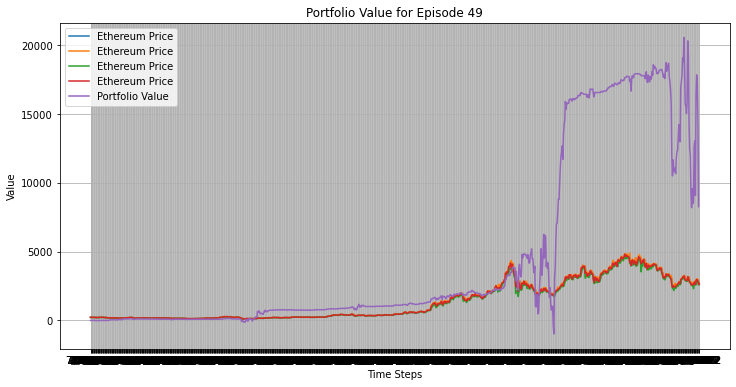

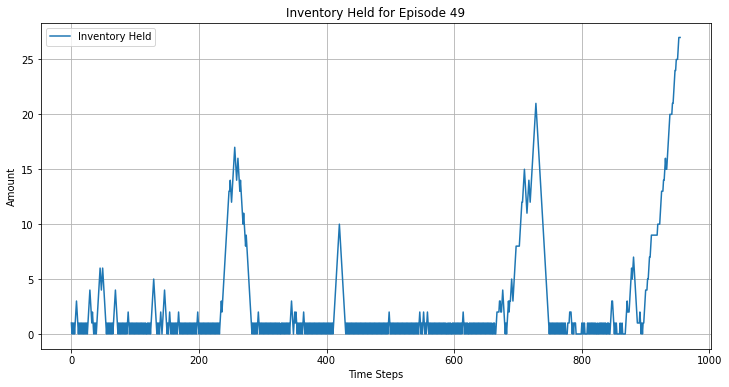

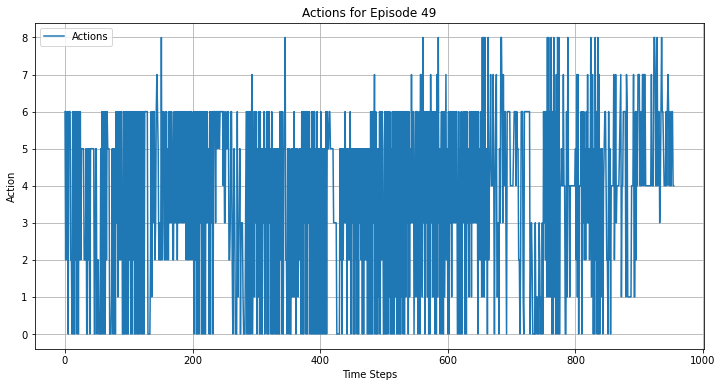

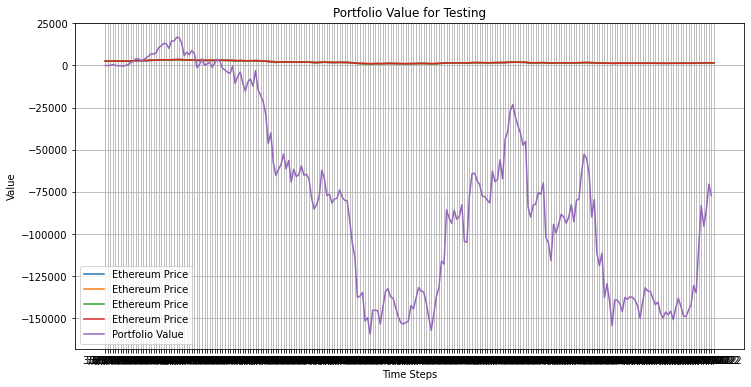

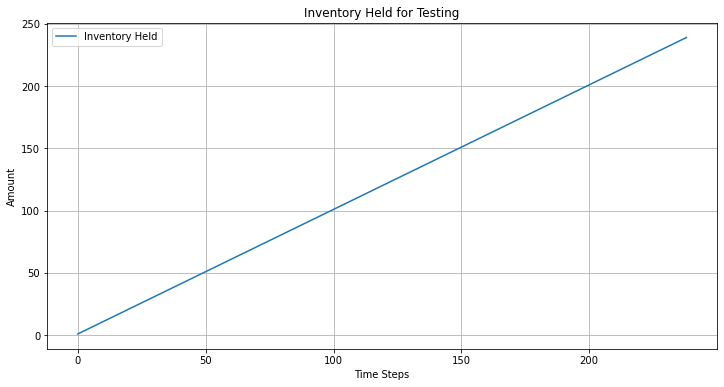

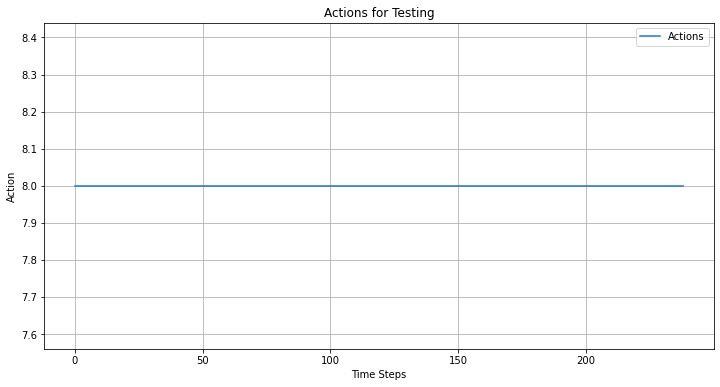

In [ ]:
import matplotlib.pyplot as plt

def plot_portfolio_value(data, title, eth_price, filename):
    plt.figure(figsize=(12, 6))
    plt.plot(eth_price, label="Ethereum Price")
    plt.plot(data["Portfolio Value"], label="Portfolio Value")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(filename)

def plot_inventory_held(data, title, filename):
    plt.figure(figsize=(12, 6))
    plt.plot(data["Inventory Size"], label="Inventory Held")
    plt.xlabel("Time Steps")
    plt.ylabel("Amount")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(filename)

def plot_actions(data, title, filename):
    plt.figure(figsize=(12, 6))
    plt.plot(data["Actions"], label="Actions")
    plt.xlabel("Time Steps")
    plt.ylabel("Action")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(filename)


# Visualize the data
# You can change the index to visualize a specific training episode

with open ("Output/episode_mem.json", "r") as f:
    episode_data = json.load(f)

with open ("Output/testing_mem.json", "r") as f:
    testing_data = json.load(f)

# look at last episode
selected_episode = len(episode_data) - 1

plot_portfolio_value(episode_data[selected_episode], f"Portfolio Value for Episode {selected_episode}", train_close, "Output/episode_portfolio.png")
plot_inventory_held(episode_data[selected_episode], f"Inventory Held for Episode {selected_episode}", "Output/episode_inventory.png")
plot_actions(episode_data[selected_episode], f"Actions for Episode {selected_episode}", "Output/episode_actions.png")

plot_portfolio_value(testing_data, f"Portfolio Value for Testing", test_close, "Output/testing_portfolio.png")
plot_inventory_held(testing_data, f"Inventory Held for Testing", "Output/testing_inventory.png")
plot_actions(testing_data, f"Actions for Testing", "Output/testing_actions.png")


